In [ ]:
!pip install opencv-python-headless
#!pip install -U "tensorflow>=2.10.0"
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import cv2
import os
import pandas as pd

import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz
import random
import shutil
import glob

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
from IPython.display import Image
from sklearn.metrics import classification_report

In [ ]:
#Mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")
#/content/drive/MyDrive/csvs/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The prepared dataset:
In order to hypertune the model, only a fraction of the dataset (40%) was used. However, for the final model, the complete subsets created in the "EDA_HAB.ipynb" (saved in folder "cleaned_actions") were used.

This code refers to training the model with the complete training dataset.

In [ ]:
# The original dataset:
#dataset_path = os.listdir('/content/drive/My Drive/csvs/handball_s/actions')

# The new directory, created to preserve the original, is "cleaned_actions".
# The train, test, and validation dataset were created from this copy "cleaned_actions".
dataset_path = os.listdir('/content/drive/My Drive/csvs/handball_test/cleaned_actions')

label_types = os.listdir('/content/drive/My Drive/csvs/handball_test/cleaned_actions')
print(label_types)

['jump-shot', 'passing', 'crossing', 'defence', 'shot']


In [ ]:
# Define the paths to the dataset folders
#dataset_path = '/content/drive/My Drive/csvs/handball_s/actions'
dataset_path = '/content/drive/My Drive/csvs/handball_test/cleaned_actions'

train_path = '/content/drive/My Drive/csvs/handball_test/prueba/train'
test_path = '/content/drive/My Drive/csvs/handball_test/prueba/test'
val_path = '/content/drive/My Drive/csvs/handball_test/prueba/val'

## Preparing dataframes for each subset:

In [ ]:
def create_dataframe_from_subset(subset_path):
    info_videos = []

    for action in os.listdir(subset_path):
        # Get all the videos in this action:
        action_path = os.path.join(subset_path, action)
        all_videos = os.listdir(action_path)

        # Add the videos to the list:
        for video in all_videos:
            video_path = os.path.join(action_path, video)
            info_videos.append((action, video_path))

    # Build DataFrame:
    df = pd.DataFrame(data=info_videos, columns=['tag', 'video_name'])
    return df

### Preparing the training data:

In [ ]:
train_df = create_dataframe_from_subset(train_path)
print(train_df.head())
print(train_df.shape)
print(train_df.tail())

       tag                                         video_name
0  passing  /content/drive/My Drive/csvs/handball_test/pru...
1  passing  /content/drive/My Drive/csvs/handball_test/pru...
2  passing  /content/drive/My Drive/csvs/handball_test/pru...
3  passing  /content/drive/My Drive/csvs/handball_test/pru...
4  passing  /content/drive/My Drive/csvs/handball_test/pru...
(141, 2)
         tag                                         video_name
136  defence  /content/drive/My Drive/csvs/handball_test/pru...
137  defence  /content/drive/My Drive/csvs/handball_test/pru...
138  defence  /content/drive/My Drive/csvs/handball_test/pru...
139  defence  /content/drive/My Drive/csvs/handball_test/pru...
140  defence  /content/drive/My Drive/csvs/handball_test/pru...


### Preparing the validation data:

In [ ]:
val_df = create_dataframe_from_subset(val_path)
print(val_df.head())
print(val_df.shape)
print(val_df.tail())

    tag                                         video_name
0  shot  /content/drive/My Drive/csvs/handball_test/pru...
1  shot  /content/drive/My Drive/csvs/handball_test/pru...
2  shot  /content/drive/My Drive/csvs/handball_test/pru...
3  shot  /content/drive/My Drive/csvs/handball_test/pru...
4  shot  /content/drive/My Drive/csvs/handball_test/pru...
(29, 2)
        tag                                         video_name
24  defence  /content/drive/My Drive/csvs/handball_test/pru...
25  defence  /content/drive/My Drive/csvs/handball_test/pru...
26  defence  /content/drive/My Drive/csvs/handball_test/pru...
27  defence  /content/drive/My Drive/csvs/handball_test/pru...
28  defence  /content/drive/My Drive/csvs/handball_test/pru...


### Preparing the test data:

In [ ]:
test_df = create_dataframe_from_subset(test_path)
print(test_df.head())
print(test_df.shape)
print(test_df.tail())

         tag                                         video_name
0  jump-shot  /content/drive/My Drive/csvs/handball_test/pru...
1  jump-shot  /content/drive/My Drive/csvs/handball_test/pru...
2  jump-shot  /content/drive/My Drive/csvs/handball_test/pru...
3  jump-shot  /content/drive/My Drive/csvs/handball_test/pru...
4  jump-shot  /content/drive/My Drive/csvs/handball_test/pru...
(54, 2)
        tag                                         video_name
49  passing  /content/drive/My Drive/csvs/handball_test/pru...
50  passing  /content/drive/My Drive/csvs/handball_test/pru...
51  passing  /content/drive/My Drive/csvs/handball_test/pru...
52  passing  /content/drive/My Drive/csvs/handball_test/pru...
53  passing  /content/drive/My Drive/csvs/handball_test/pru...


### _Save each dataframe in a '.csv'_

In [ ]:
# Save DataFrames to CSV files
# data_path = '/content/drive/My Drive/csvs/handball_test/prueba'
# train_df.to_csv(os.path.join(data_path, 'train.csv'), index=False)
# test_df.to_csv(os.path.join(data_path, 'test.csv'), index=False)
# val_df.to_csv(os.path.join(data_path, 'val.csv'), index=False)

# Preparation of input:
Source of the functions to prepare the dataset: https://github.com/AarohiSingla/Video-Classifier-Using-CNN-and-RNN/blob/main/video_classifier_working.ipynb

## Preparation of video frames

In [ ]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
IMG_SIZE = 224

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

## Encoding the labels for the video

In [ ]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
# Get the vocabulary from the label_processor
vocab = label_processor.get_vocabulary()
print(vocab)

labels = train_df["tag"].values
labels = label_processor(labels[..., None]).numpy() #numeric label for each action

['crossing', 'defence', 'jump-shot', 'passing', 'shot']


The labels have been encoded to create the input tensors:

In [ ]:
# Print the unique labels and their corresponding meanings (decoded labels)
unique_labels = np.unique(train_df["tag"].values)
for label in unique_labels:
    # Process each label individually by wrapping it in a list
    encoded_label = label_processor([label])[0].numpy()
    decoded_label = vocab[int(encoded_label)]
    print(f"Encoded Label: {encoded_label}, Decoded Label: {decoded_label}")

Encoded Label: 0, Decoded Label: crossing
Encoded Label: 1, Decoded Label: defence
Encoded Label: 2, Decoded Label: jump-shot
Encoded Label: 3, Decoded Label: passing
Encoded Label: 4, Decoded Label: shot


# Building the model:
This model will consist of a feature extractor followed by a sequential neural network.

In [ ]:
#Define hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 4
#EPOCHS = 80

MAX_SEQ_LENGTH = 16
NUM_FEATURES = 2048

## Residual CNN: feature extraction
Deep residual networks (ResNets) consist of many stacked “Residual Units”. These residual networks are easier to optimize, and can gain accuracy from considerably increased depth. In this model, "ResNet101V2" will be used.<br>
When using other deep neural networks for feature extraction, a degradation problem was  observed: with the network depth increasing, accuracy gets saturated (which might be unsurprising) and then degrades rapidly. Learning is very unstable. Hence, a neural network specifically with residual connections is used to tackle to this problem.

Source: [He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7780459)


In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.ResNet101V2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.resnet_v2.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

### Running the feature extractor:

Function that will generate the input for the next step of the model:

In [ ]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    ##take all classlabels from train_df column named 'tag' and store in labels
    labels = df["tag"].values

    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to the sequence model.
    # `frame_masks` a NumPy array used to indicate which timesteps in a sequence
    # are masked with padding and which are not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") # num_samples,10
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") #num_samples,10,2048

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(path)
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # EXTRACT FEATURES from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


In [ ]:
train_data, train_labels = prepare_all_videos(train_df)
test_data, test_labels = prepare_all_videos(test_df)
val_data, val_labels = prepare_all_videos(val_df)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"Frame features in val set: {val_data[0].shape}")
print(f"Frame masks in val set: {val_data[1].shape}")


print(f"train_labels in train set: {train_labels.shape}")
print(f"val_labels in val set: {val_labels.shape}")

print(f"test_labels in val set: {test_labels.shape}")


1/1 [==============================] - 0s 26ms/step
Frame features in train set: (141, 16, 2048)
Frame masks in train set: (141, 16)
Frame features in val set: (29, 16, 2048)
Frame masks in val set: (29, 16)
train_labels in train set: (141, 1)
val_labels in val set: (29, 1)
test_labels in val set: (54, 1)


## RNN: time dimension
In this phase, the sequential layers are introduced to learn higher level parameters, while feature extraction was accomplished using CNN. The sequential layers can deal with the issue of vanishing gradients efficiently, unlocking certain memory positions in a spatial context.
The type of recurrent layer that is used for this is the gated recurrent unit (GRU). This layer makes each recurrent unit to adaptively capture dependencies of different time scales, similarly to long short-term memory units (LSTM), but without having a separate memory cell.

Source:

[Montaha, Sidratul, et al. "Timedistributed-cnn-lstm: A hybrid approach combining cnn and lstm to classify brain tumor on 3d mri scans performing ablation study." IEEE Access 10 (2022): 60039-60059.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9786658)

[Chung, Junyoung, et al. "Empirical evaluation of gated recurrent neural networks on sequence modeling." arXiv preprint arXiv:1412.3555 (2014).](https://arxiv.org/pdf/1412.3555.pdf)

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(10)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(7, activation="relu")(x)
    x = keras.layers.Dense(6, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

### Running the RNN:

In [ ]:
EPOCHS = 150
# Utility for running experiments.
def run_rnnmodel():
    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_data=([val_data[0], val_data[1]], val_labels),  # Include validation data
        epochs=EPOCHS,
        callbacks=tf.keras.callbacks.EarlyStopping(patience = 15, monitor = 'val_loss'),
    )

    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [ ]:
history, sequence_model = run_rnnmodel()

Epoch 1/150
5/5 [==============================] - 11s 603ms/step - loss: 1.6672 - accuracy: 0.1773 - val_loss: 1.5967 - val_accuracy: 0.2759
Epoch 2/150
5/5 [==============================] - 0s 20ms/step - loss: 1.5466 - accuracy: 0.2766 - val_loss: 1.5651 - val_accuracy: 0.2759
Epoch 3/150
5/5 [==============================] - 0s 21ms/step - loss: 1.5236 - accuracy: 0.2766 - val_loss: 1.5557 - val_accuracy: 0.2759
Epoch 4/150
5/5 [==============================] - 0s 21ms/step - loss: 1.4429 - accuracy: 0.3759 - val_loss: 1.5304 - val_accuracy: 0.1724
Epoch 5/150
5/5 [==============================] - 0s 21ms/step - loss: 1.3699 - accuracy: 0.3972 - val_loss: 1.4844 - val_accuracy: 0.2759
Epoch 6/150
5/5 [==============================] - 0s 20ms/step - loss: 1.3615 - accuracy: 0.3901 - val_loss: 1.4574 - val_accuracy: 0.3103
Epoch 7/150
5/5 [==============================] - 0s 19ms/step - loss: 1.2776 - accuracy: 0.3972 - val_loss: 1.4484 - val_accuracy: 0.3793
Epoch 8/150
5/5 [=

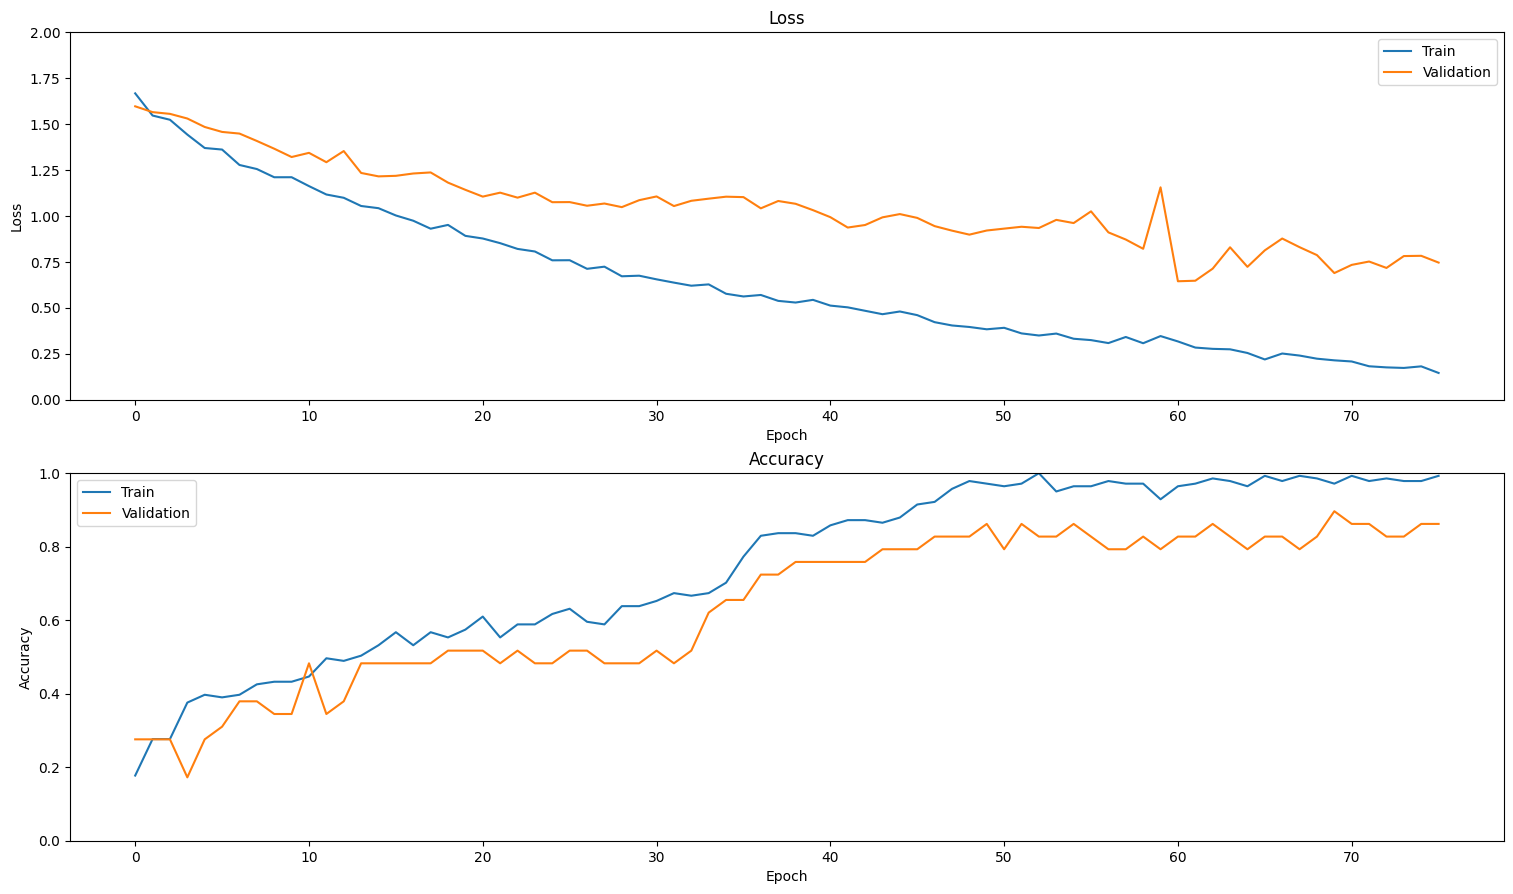

In [ ]:
def plot_history(sequence_model):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

It can be seen that the Recurrent network (phase 2 of the model) takes 2 inputs: the feature masks and the frame masks.

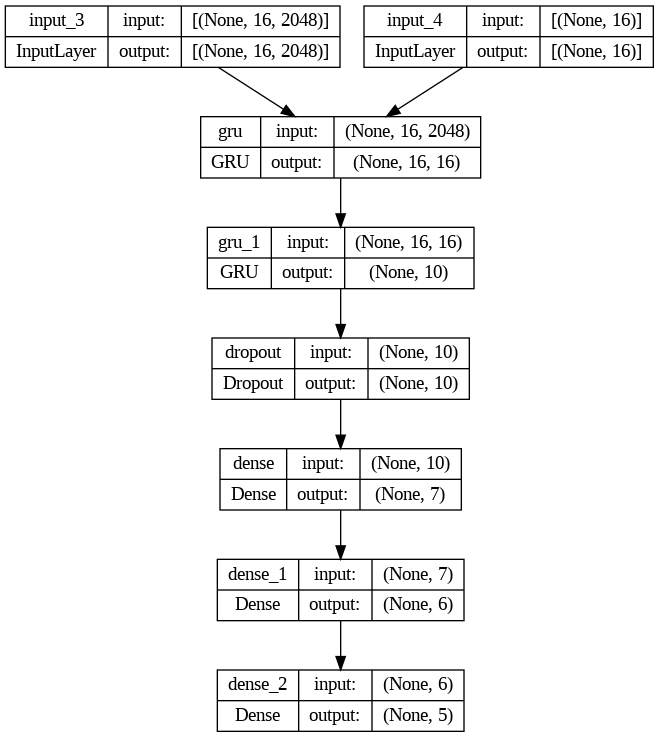

In [ ]:
plot_model(sequence_model, show_shapes=True, show_layer_names=True)

# Further evaluation

In [ ]:
# Make predictions on the test data
y_pred = sequence_model.predict([test_data[0], test_data[1]])

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate a classification report
class_report = classification_report(test_labels, y_pred_classes)
print("Classification Report:")
print(class_report)

2/2 [==============================] - 2s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.36      0.42        11
           1       0.73      0.73      0.73        11
           2       0.45      0.82      0.58        11
           3       0.56      0.45      0.50        11
           4       0.17      0.10      0.12        10

    accuracy                           0.50        54
   macro avg       0.48      0.49      0.47        54
weighted avg       0.49      0.50      0.48        54



In [ ]:
# Print the unique labels and their corresponding meanings (decoded labels)
unique_labels = np.unique(train_df["tag"].values)
for label in unique_labels:
    # Process each label individually by wrapping it in a list
    encoded_label = label_processor([label])[0].numpy()
    decoded_label = vocab[int(encoded_label)]
    print(f"Encoded Label: {encoded_label}, Decoded Label: {decoded_label}")

Encoded Label: 0, Decoded Label: crossing
Encoded Label: 1, Decoded Label: defence
Encoded Label: 2, Decoded Label: jump-shot
Encoded Label: 3, Decoded Label: passing
Encoded Label: 4, Decoded Label: shot


# Saving models:
The models will be saved in the TensorFlow SavedModel format.

In [ ]:
path_to_save_model = '/content/drive/My Drive/csvs/handball_test/models/kinda_good_seq_cnn'

In [ ]:
model = sequence_model

In [ ]:
# Save the model in TensorFlow SavedModel format
tf.saved_model.save(model, path_to_save_model)
